# Data and EDA

We have downloaded our respective datasets, but we need to separate the data that we want, from the datasets that we have. 

### Datasets

#### Fast Food Classification V2
```
- test
|   |
|   - folders of class
|              |
|              - images of class.
- train
|   |
|   - folders of class
|              |
|              - images of class.
- valid
|   |
|   - folders of class
|              |
|              - images of class.
```

#### Oxford Pets
```
- annotations
|   |
|   - information about the dataset.
|              
- images
|   |
|   - the images of the dataset (title has label in it).
|              
- valid
|   |
|   - folders of class
|              |
|              - images of class.
```

#### Stanford Dogs
```
- annotations
|   |
|   - Annotation
|              |
|              - folders of each class
|                        |
|                        - annotation information for each image in the classes.
|
- images
|   |
|   - Images
|        |
|        - folders of each class 'c'
|                   |
|                   - images of dogs belonging to class 'c'.
```

We are going to be using PyTorch Datasets, specifically we are going to use the `ImageFolder` so eventually, we need to get our dataset into the format of `root/class_folders/images`. 

## Creating Our Dataset

In [1]:
from pathlib import Path
import os
import shutil

In [2]:
# Data directories.
root_data_dir = Path.cwd() / "original_data"
fast_food = root_data_dir / "Fast Food Classification V2"
oxford_pets = root_data_dir / "OxfordPets"
stanford_dogs = root_data_dir / "StanfordDogs"


#### Sorting Oxford Pet Dataset

Lets now sort out how to collect each of our samples from the Oxford Pet Dataset, we are dealing with cats and dogs in this dataset, luckily the makers have given all the dog images names that start with a lower case letter, and cat images names that start with an upper case letter. 

We are going to scan the directory, if the letter is lowercase, we will create a folder for that dog type, then fill it with all of the images of that class of dog. 

In [3]:
def collect_class_names(source_dir):
    class_names = []
    for dir_object in os.scandir(source_dir):
        if dir_object.name[0].islower():
            name = dir_object.name.split('_')[:-1]
            name = "_".join(name)
            class_names.append(name)
    return class_names

def create_dirs(class_names:list, source_folder:Path, destination_folder:Path):
    for class_name in class_names:
        
        class_dir = destination_folder / class_name
        if not ((destination_folder / class_name).is_dir()):
            os.mkdir(class_dir)

        for img_path in os.listdir(source_folder):
            if class_name in img_path:
                shutil.move(source_folder / img_path, destination_folder / class_name)

source_dir = oxford_pets / "images"
destination_dir = Path("./data/")
class_names = collect_class_names(source_dir)
create_dirs(class_names, source_dir, destination_dir)

Okay so we have now got a certain amount of our dog data into class folders. We can now either add the Stanford dogs to the existing folders (if we already have data for them) or we create new folders and add them there. 


#### Sorting Stanford Dogs Dataset

In [4]:
for class_folder in os.scandir(stanford_dogs / "images/Images"):
    
    # getting the class names
    class_name = class_folder.name.lower().split('-')[1:]
    class_name = "_".join(class_name)

    # checking if the class dir already exists, if not, make one
    class_dir = Path('./data/' + class_name)
    if not class_dir.is_dir():
        os.mkdir(class_dir)

    if ".DS_Store" in class_folder.path:
        continue

    for img in os.listdir(class_folder.path):
        img_path = os.path.join(class_folder.path, img)
        shutil.move(img_path, class_dir)


Okay, so we have all of our classes together. We have the different breeds of dogs and we have the photos of donuts. We have ALOT of classes, alot more than I originally expected, lets do some filtering and remove some classes then we will do some EDA.

Looking at the classes, I am going to remove some in order to decrease the complexity of the task my model has to learn. I am going to expand the project once I have an MVP and a trained model for the task. We have also found that some classes are the same dog, just with different names (such as Basset vs Basset_hound, staffordshire_bull_terrier vs staffordshire_bullterrier) such classes have been combined. 

We have also combined certain breeds such as spaniels, poodles, pitbulls etc where they might differ slightly in features but the all belong to the same "class" of dog. 

## Becoming One With Our Data

One of the most important things in an ML engineers workflow is getting to know our data. Lets try and answer some important questions about what our data is, and what we plan to do with it!

Lets go through some questions we want to answer.
- What are we working with?
    - *We are working with image data (RGB) of dogs and donuts lol.*
    - *We have a total of 17,126 images in our dataset.*
    - *We have 57 classes in our dataset.*
- What is the distribution of classes in the dataset?
    - *Yes there are, but we can improve our situation with data augmentation.*
- What is the average size/resolution of the images?
    - *There is a vast array of picture sizes so we will have to adjust them to a common size.*
- Are there any outliers or anomalies in the dataset?
- Are there any missing or corrupted images in the dataset?
    - *PIL will throw an exception if it can't open an image because of corruption! So all sorted there.*
- Are there any duplicate images in the dataset?
    - *No there are no duplicate images in our dataset, we have checked using hashing.*
- Is there any metadata available for the images (e.g., labels, tags, descriptions)?
    - *No there is no metadata, we just have the images and we have nested them in a folder structure that will allow us to process them effectively.* 
- Are there any relationships or patterns between different classes?
- Can we perform any data augmentation techniques to increase the size of the dataset?
    - Yes, we can use Torchvision Transform to augment our data [see here](https://pytorch.org/vision/master/transforms.html#), but we will go into detail about the transformations we are using when it comes to training the model. 

    

These questions will allow us to draw some insights into the data we will be training with. 

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import numpy as np
from pathlib import Path
from PIL import Image

In [20]:
# Collect the number of instancs in a class, if there are no instances, remove the dir. 
data_dir = Path("./data")
num_of_classes = {}
for data_class in os.listdir(data_dir):
    class_path = data_dir / data_class
    num_class_instances = len(os.listdir(class_path))
    if num_class_instances == 0:
        os.rmdir(class_path)
    else:
        num_of_classes[str(class_path.name)] = num_class_instances

print(f"There are {sum(num_of_classes.values())} instances in our dataset.")
print(f"There are {len(num_of_classes.keys())} instances in our dataset.")

There are 17126 instances in our dataset.
There are 57 instances in our dataset.


### Plotting Class Distributions

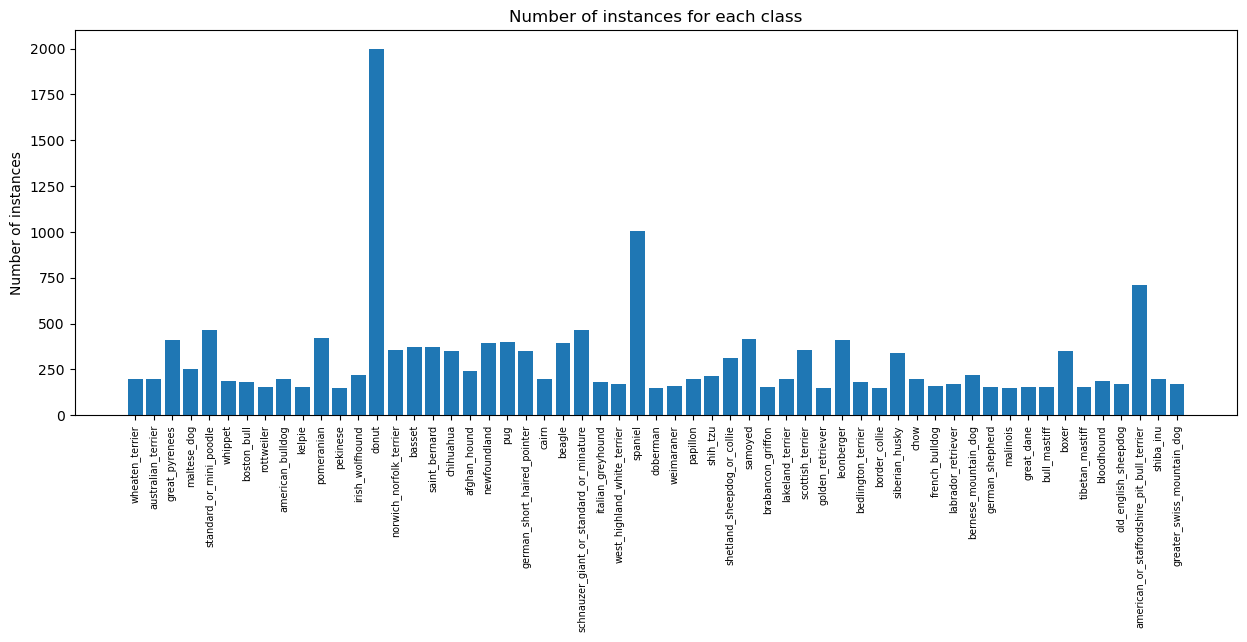

In [5]:
# Lets plot the class distributions
figure = plt.figure(figsize=(15, 5))
ax = figure.add_subplot(111)
ax.bar(x=range(len(num_of_classes)), height=num_of_classes.values())
ax.set_xticks(range(len(num_of_classes)), list(num_of_classes.keys()), rotation=90, fontsize=7)
ax.set_ylabel("Number of instances")
plt.title("Number of instances for each class")
plt.show()

We can see here that we have a rather even distribution of labels between the dog classes. Due to the combination of certain dog classes, we have a few classes that are slightly more represented (spaniel, pit bull appear to be the largest). We are going to perform data augmentation in order to artificially increase the size of our dataset so nothing to be worried about. 

### Plotting Image Size Distribution

In [6]:
# Lets work out the resolution of the images we are working with
resolution_counts = {}
for data_class in os.listdir(data_dir):
    class_path = data_dir / data_class
    for image in os.listdir(class_path):
        img = Image.open(class_path / image)
        if tuple(img.size) not in resolution_counts.keys():
            resolution_counts[tuple(img.size)] = 1
        else:
            resolution_counts[tuple(img.size)] +=1

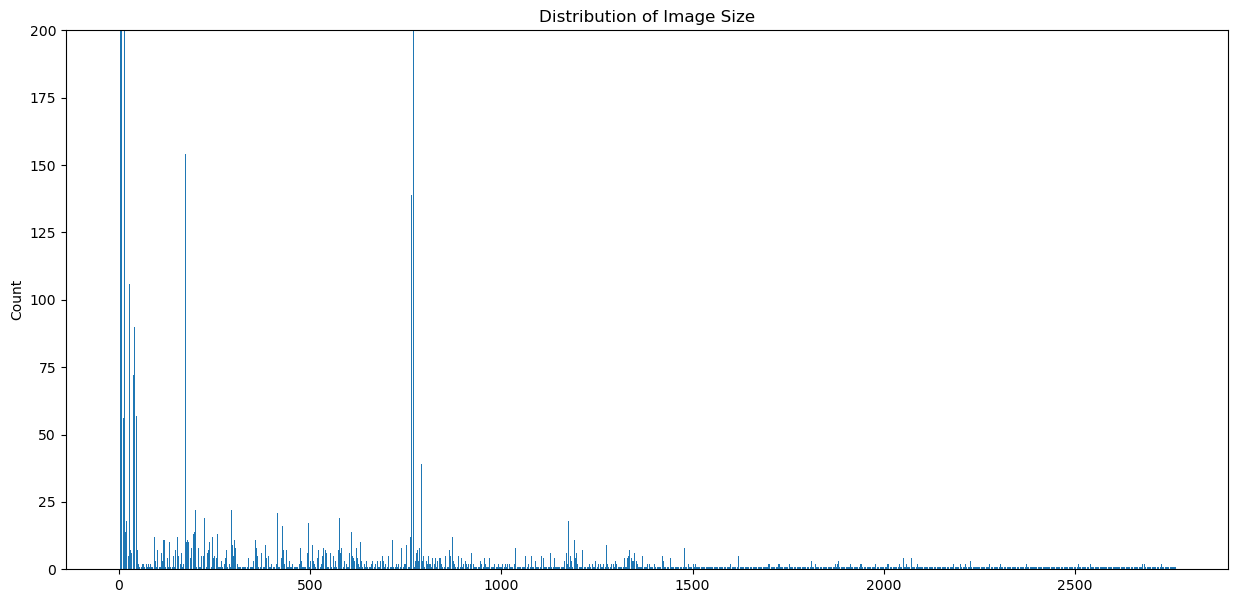

In [7]:
# Lets plot the class distributions
figure = plt.figure(figsize=(15, 7))
ax = figure.add_subplot(111)
ax.bar(x=range(len(resolution_counts)), height=resolution_counts.values())
# ax.set_xticks(range(len(resolution_counts)), list(resolution_counts.keys()), rotation=90, fontsize=3) 
ax.set_ylabel("Count")
ax.set_ylim(0, 200) # There are much more than 200 for some images but I want to see the small ones.
plt.title("Distribution of Image Size")
plt.show()

We have a wide range of image sizes, we will need to preprocess them into a standard size. To do this, we need to think about what 'part' of the image we actually want, ideally we will resize all images down to (224, 224) but we want to make sure that we are getting the center of the image. 

### Plotting Random Class Images

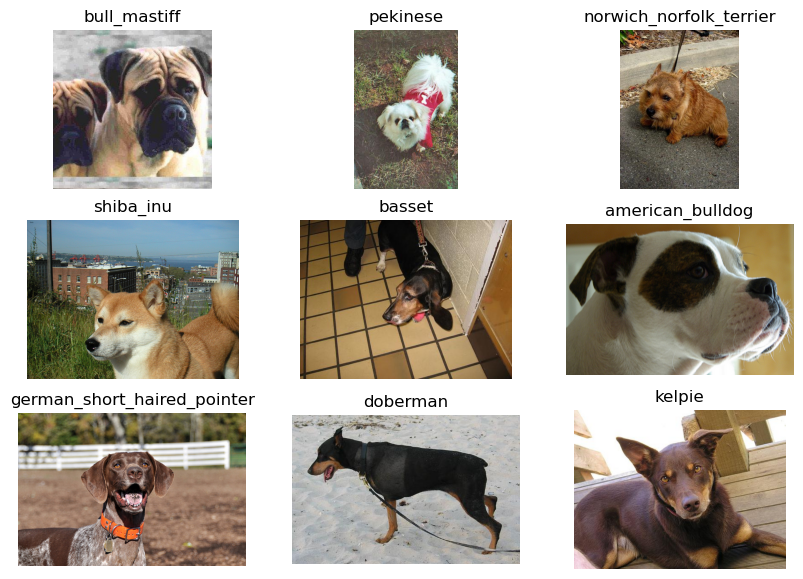

In [9]:
# Lets plot an image from some random classes in our dataset. 

# Collects random class paths and creates random idx list
len_of_classes = len(os.listdir(data_dir))
random_class_idx = np.random.randint(low=0, high=len_of_classes, size=9)

# function that plots the data
def plot_random_class_instance(data_path, random_class_idx):
    rows, cols = 3, 3
    figure = plt.figure(figsize=(10, 7))
    img_counter = 1

    # Collect the image and plot it.
    data_list = os.listdir(data_path)
    for index in random_class_idx:
        class_we_plot = data_path / data_list[index]
        image_paths = os.listdir(class_we_plot)
        rnd_image_idx = np.random.randint(low=0, high=len(image_paths), size=1)[-1]
        image_we_plot = class_we_plot / image_paths[rnd_image_idx]
        img = Image.open(image_we_plot)

        figure.add_subplot(rows, cols, img_counter)
        plt.imshow(img)
        plt.title(class_we_plot.stem)
        plt.axis(False)

        img_counter += 1


plot_random_class_instance(data_dir, random_class_idx)




Some classes will be hard to differentiate between, even after combining some of the classes, I think we will still have some problems. This is why we need to create the data-fly-wheel. 

## Checking for Duplicate Images

To check for duplicate images, we are going to hash each image, if the hash is the same, then we have a duplicate image.

We look through our dataset, and use the `hashlib` `sha1` method to hash each image. We can then check to see if any of the hashes have multiple images in their values. If they do, then we have a duplicate image.

In [11]:
from hashlib import sha1

In [19]:
hash_dict = {}
for data_class in os.listdir(data_dir):
    class_path = data_dir / data_class
    for image in os.listdir(class_path):
        hash = sha1(open(class_path / image, 'rb').read())
        if hash in hash_dict.keys():
            hash_dict[hash].append(image)
        else:
            hash_dict[hash] = [image]

for hash_key, value_list in hash_dict.items():
    if len(value_list) > 1:
        print("We have a duplicate")
        print(value_list)

No duplicates found! 

## Splitting into Training and Test Sets



total 1880
drwxr-xr-x   7 cameronwheeler  staff     224 Oct 17 07:41 .
drwxr-xr-x   7 cameronwheeler  staff     224 Oct 15 20:59 ..
-rw-r--r--   1 cameronwheeler  staff    2048 Oct 18 09:24 .gitignore
-rw-r--r--   1 cameronwheeler  staff      14 Oct 16 07:54 README.md
drwxr-xr-x  59 cameronwheeler  staff    1888 Oct 27 21:18 data
-rw-r--r--   1 cameronwheeler  staff  951275 Oct 28 23:10 data_exploration.ipynb
drwxr-xr-x   6 cameronwheeler  staff     192 Oct 18 16:18 original_data
